<a href="https://colab.research.google.com/github/santyxd3000/Caso1-InfraComp/blob/main/Fault_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO DE GRADO - CLASIFICACIÓN DE FALLAS**

Santiago Pardo Morales - 202013025

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import datetime
import scipy
sns.set()
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import io
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from scipy.optimize import curve_fit

In [97]:
ae_df = pd.read_csv('df_with_anomalies.csv',sep=';')
iqr_df = pd.read_csv('statistical_df_with_anomalies.csv',sep=';')
#sensor = pd.read_csv('sensor_data.csv',sep=';').dropna()

In [98]:
#ae_df = pd.merge(ae_df1, sensor, how="inner", on=["Timestamp"])

In [99]:
anomaly_iqr = iqr_df[iqr_df['Anomaly']==1]
no_anomaly_iqr = iqr_df[iqr_df['Anomaly']==0]

In [100]:
anomaly_ae = ae_df[ae_df['Anomaly']==1]
no_anomaly_ae = ae_df[ae_df['Anomaly']==0]

In [101]:
#Coincidencias con modelo estadístico
print(anomaly_iqr['Timestamp'].isin(anomaly_ae['Timestamp']).sum())

43418


## **COMPARACIÓN FINAL CON MÉTODO ESTADÍSTICO**

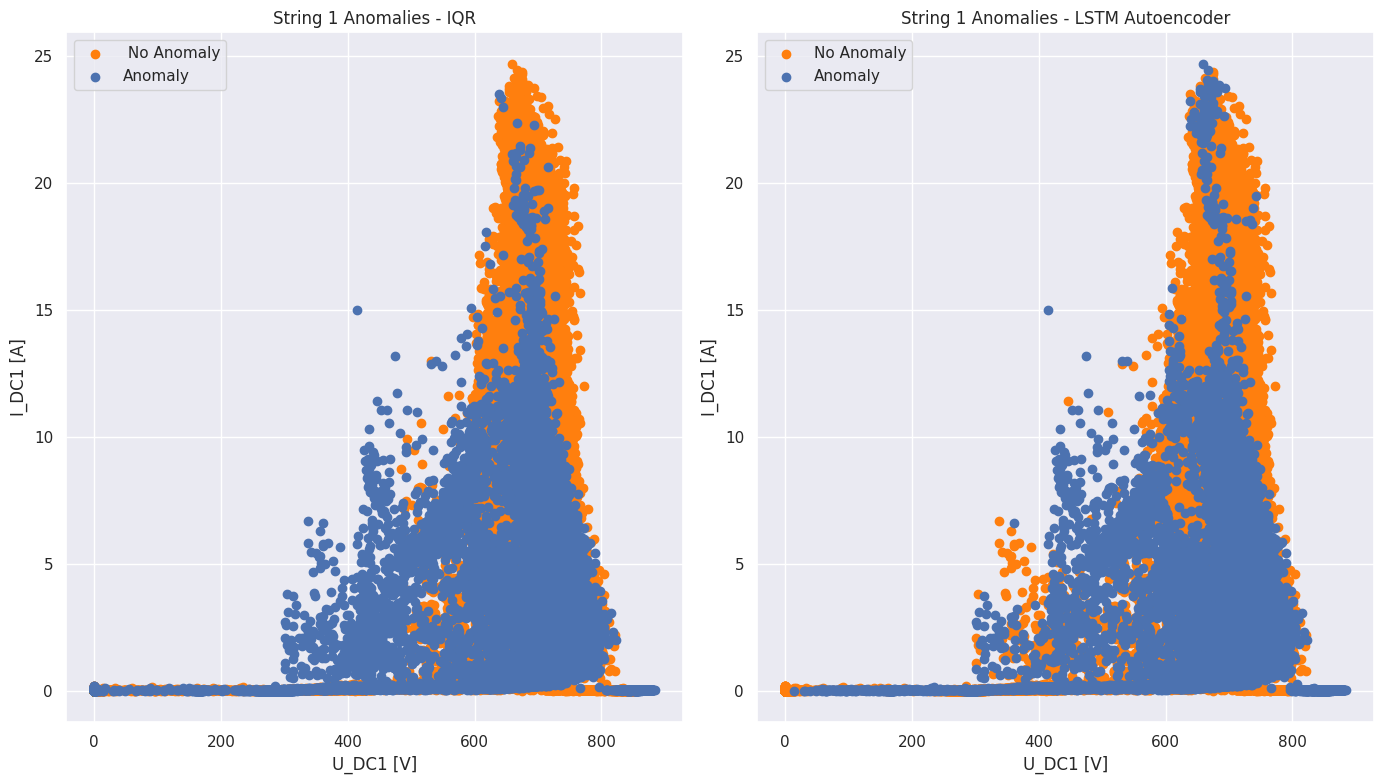

In [102]:
#STRING1

# Gráfico 1
plt.figure(figsize=(14, 8))

# Gráfico 1
plt.subplot(1,2,1)
plt.scatter(no_anomaly_iqr['U_DC1'], no_anomaly_iqr['I_DC1'], label=' No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_iqr['U_DC1'], anomaly_iqr['I_DC1'], label='Anomaly',color='b')
plt.xlabel('U_DC1 [V]')
plt.ylabel('I_DC1 [A]')
plt.legend()
plt.title('String 1 Anomalies - IQR')

# Gráfico 2
plt.subplot(1,2,2)
plt.scatter(no_anomaly_ae['U_DC1'], no_anomaly_ae['I_DC1'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC1'], anomaly_ae['I_DC1'], label='Anomaly',color='b')
plt.xlabel('U_DC1 [V]')
plt.ylabel('I_DC1 [A]')
plt.legend()
plt.title('String 1 Anomalies - LSTM Autoencoder')


# Ajustes de diseño
plt.tight_layout()
plt.show()

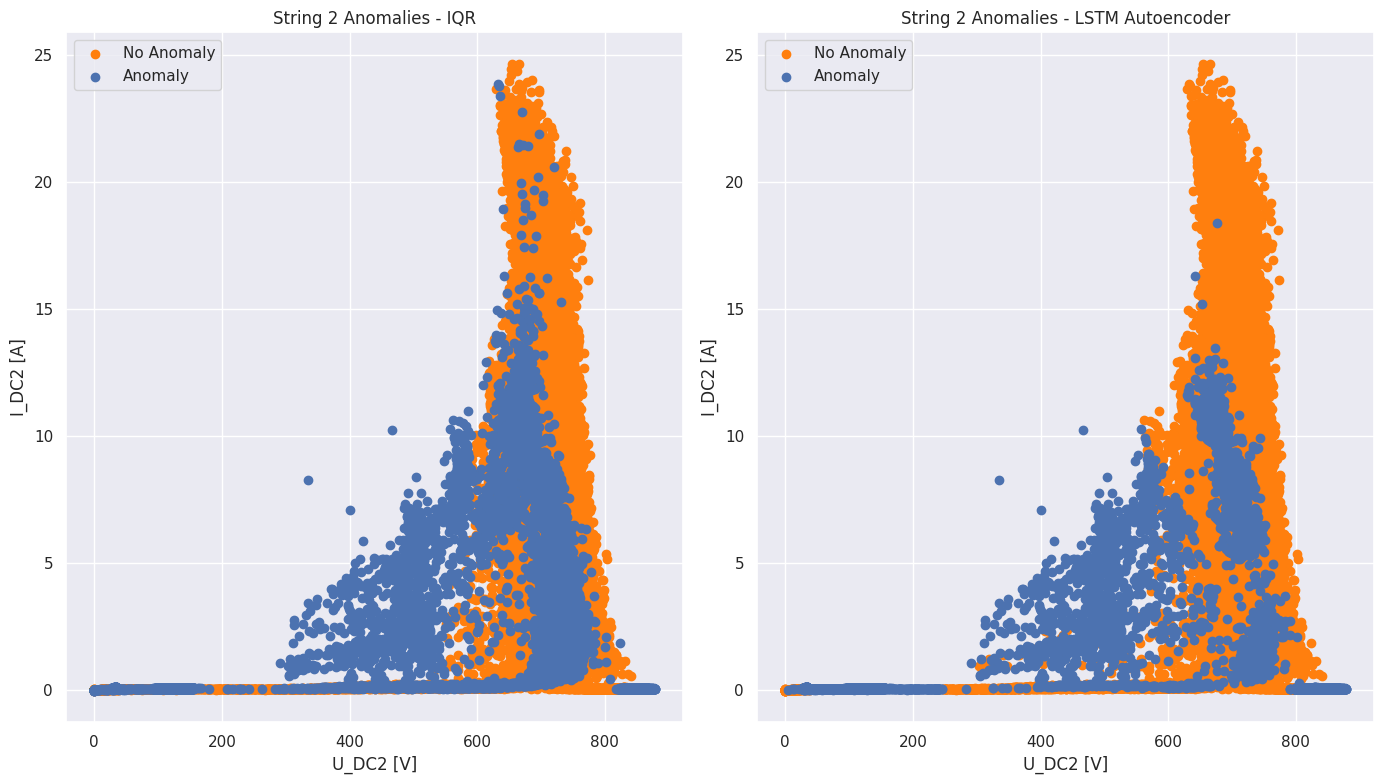

In [103]:
#STRING2

# Gráfico 1
plt.figure(figsize=(14, 8))

# Gráfico 1
plt.subplot(1,2,1)
plt.scatter(no_anomaly_iqr['U_DC2'], no_anomaly_iqr['I_DC2'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_iqr['U_DC2'], anomaly_iqr['I_DC2'], label='Anomaly',color='b')
plt.xlabel('U_DC2 [V]')
plt.ylabel('I_DC2 [A]')
plt.legend()
plt.title('String 2 Anomalies - IQR')

# Gráfico 2
plt.subplot(1,2,2)
plt.scatter(no_anomaly_ae['U_DC2'], no_anomaly_ae['I_DC2'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC2'], anomaly_ae['I_DC2'], label='Anomaly',color='b')
plt.xlabel('U_DC2 [V]')
plt.ylabel('I_DC2 [A]')
plt.legend()
plt.title('String 2 Anomalies - LSTM Autoencoder')


# Ajustes de diseño
plt.tight_layout()
plt.show()

In [104]:
#Inicializar etiquetas - No fault
ae_df['Label'] = 'No Fault'
ae_df['Anomaly_String1'] = 'No Fault'
ae_df['Anomaly_String2'] = 'No Fault'

In [105]:
ae_df

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2
0,2019-08-02 16:25:00,777.010,768.710,2.700,2.607,0,No Fault,No Fault,No Fault
1,2019-08-02 16:30:00,761.130,745.964,3.862,3.748,0,No Fault,No Fault,No Fault
2,2019-08-02 16:35:00,736.754,742.908,3.228,3.192,0,No Fault,No Fault,No Fault
3,2019-08-02 16:40:00,731.928,732.224,2.568,2.484,0,No Fault,No Fault,No Fault
4,2019-08-02 16:45:00,723.546,720.698,1.654,1.640,0,No Fault,No Fault,No Fault
...,...,...,...,...,...,...,...,...,...
150393,2023-06-02 10:10:00,712.860,698.410,15.514,15.758,0,No Fault,No Fault,No Fault
150394,2023-06-02 10:15:00,703.810,696.148,16.136,16.278,0,No Fault,No Fault,No Fault
150395,2023-06-02 10:20:00,702.586,466.782,16.520,10.250,1,No Fault,No Fault,No Fault
150396,2023-06-02 10:25:00,703.080,32.316,15.754,0.080,1,No Fault,No Fault,No Fault


## **ENCONTRAR VMP y IMP**

In [106]:
ae_df['P_DC1'] = ae_df['U_DC1']*ae_df['I_DC1']
ae_df['P_DC2'] = ae_df['U_DC2']*ae_df['I_DC2']

In [107]:
ae_df['P_DC1'].idxmax()

9019

In [108]:
ae_df['P_DC2'].idxmax()

9033

In [109]:
v_mp1 = ae_df['U_DC1'].iloc[9019]
i_mp1 = ae_df['I_DC1'].iloc[9019]

In [110]:
v_mp1,i_mp1

(716.312, 23.022)

In [111]:
v_mp2 = ae_df['U_DC2'].iloc[9033]
i_mp2 = ae_df['I_DC2'].iloc[9033]

In [112]:
v_mp2,i_mp2

(685.026, 24.02)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


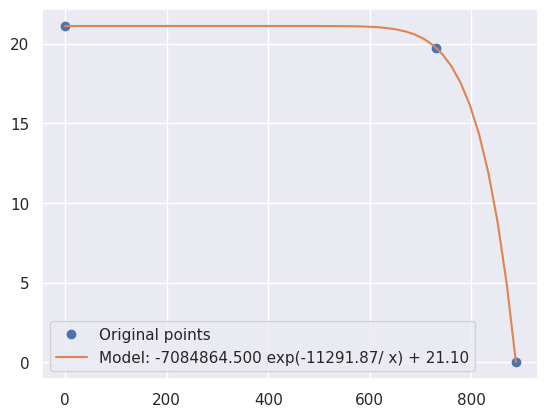

In [113]:
x = np.array([ 0.01,730.8,887.4])
y = np.array([21.1,19.72,0.01])

def fun(x, a, b, c):
    return a*np.exp(b/x)+c

coef,_ = curve_fit(fun, x, y)

plt.plot(x, y, 'o', label='Original points')
plt.plot(np.linspace(x[0],x[-1]), fun(np.linspace(x[0],x[-1]), *coef), label=f'Model: %5.3f exp(%4.2f/ x) + %4.2f' % tuple(coef) )
plt.legend()
plt.show()

## STRING 1

<ipython-input-114-3dd69495bb64>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')


Text(0.1, 0.85, '1000 W/m^2')

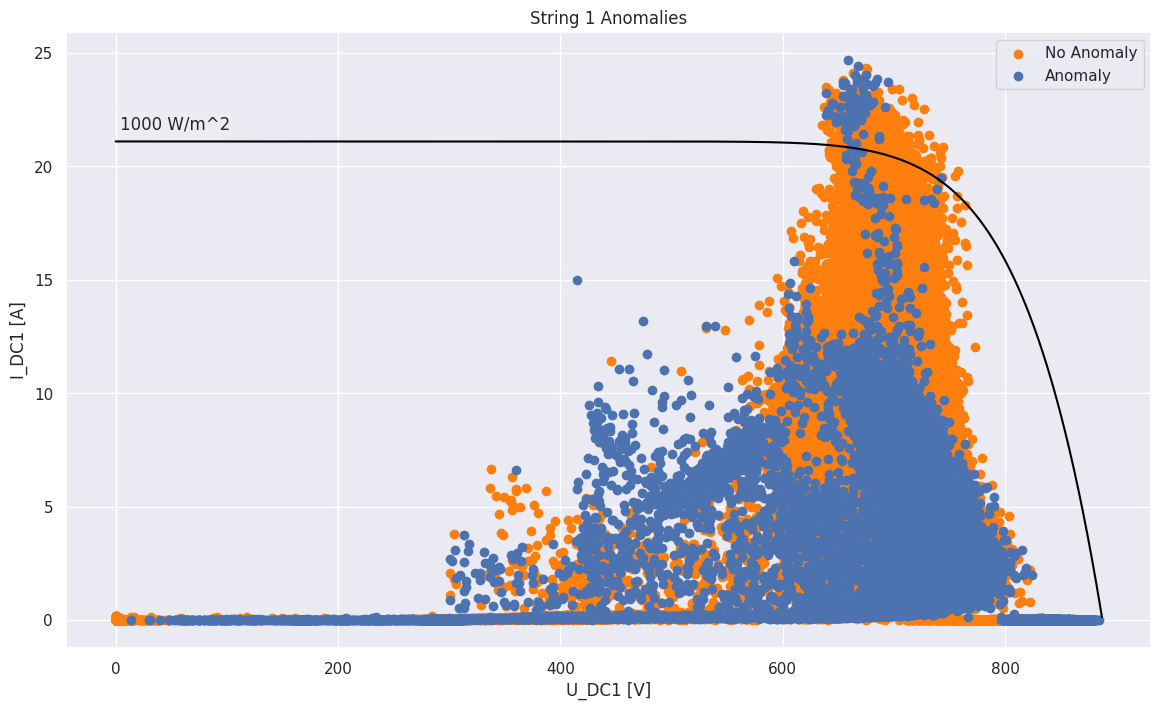

In [114]:
plt.figure(figsize=(14, 8))
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.plot(x, y, 'r', color='black')
plt.scatter(no_anomaly_ae['U_DC1'], no_anomaly_ae['I_DC1'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC1'], anomaly_ae['I_DC1'], label='Anomaly',color='b')
plt.xlabel('U_DC1 [V]')
plt.ylabel('I_DC1 [A]')
plt.legend()
plt.title('String 1 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))

In [115]:
ae_df['P_DC1'].mean()

2918.472676096883

In [116]:
ae_df[(ae_df['P_DC1'] >= 2915) & (ae_df['P_DC1'] <= 2920) & (ae_df['I_DC1'] > 6)]

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
3519,2019-08-27 16:20:00,476.516,744.416,6.126,1.646,1,No Fault,No Fault,No Fault,2919.137016,1225.308736


In [117]:
ae_df[(ae_df['P_DC1'] >= 2915) & (ae_df['P_DC1'] <= 2920) & (ae_df['U_DC1'] > 400) & (ae_df['U_DC1'] < 500)]

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
3519,2019-08-27 16:20:00,476.516,744.416,6.126,1.646,1,No Fault,No Fault,No Fault,2919.137016,1225.308736


In [118]:
ae_df['I_DC1'].mean()

4.134151039242543

In [119]:
ae_df['U_DC1'].mean()

693.9819170002261

### SOMBREO

<ipython-input-120-a28e8f21fe03>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')
<ipython-input-120-a28e8f21fe03>:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x_mean_power1_yaxis, y_mean_power1_yaxis, 'r', color='purple')
<ipython-input-120-a28e8f21fe03>:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x_mean_power1_xaxis, y_mean_power1_xaxis, 'r', color='purple')
<ipython-input-120-a28e8f21fe03>:38: UserWarning: color i

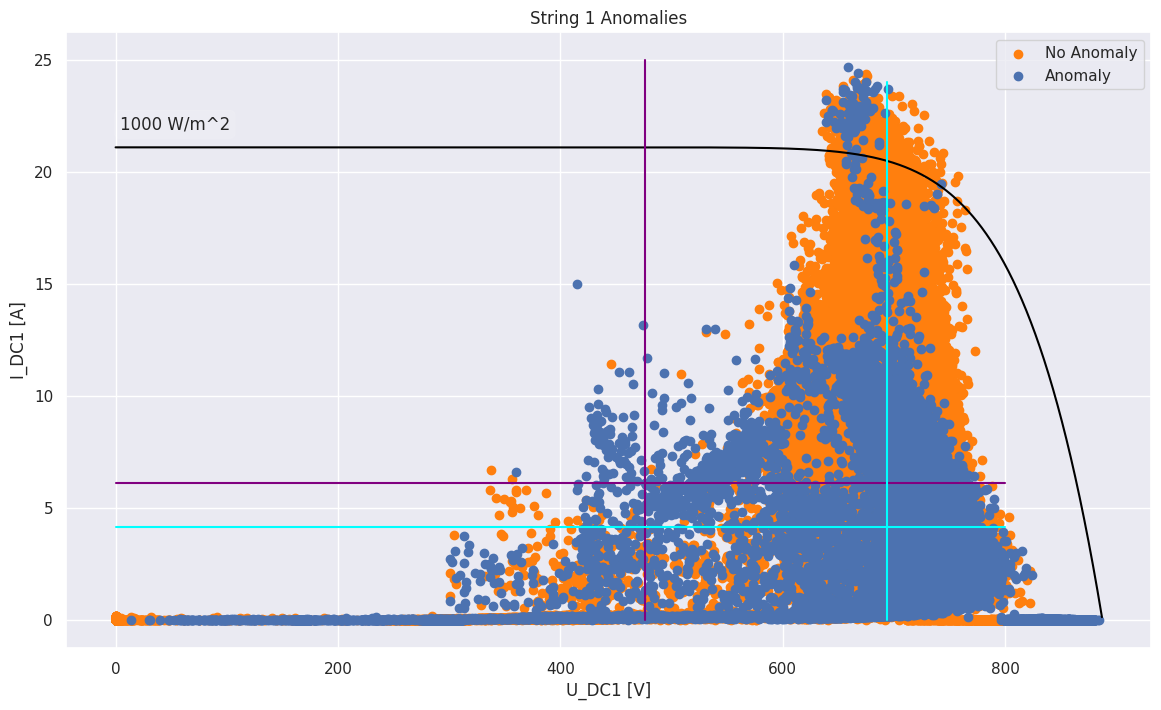

In [120]:
plt.figure(figsize=(14, 8))
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.plot(x, y, 'r', color='black')
plt.scatter(no_anomaly_ae['U_DC1'], no_anomaly_ae['I_DC1'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC1'], anomaly_ae['I_DC1'], label='Anomaly',color='b')
plt.xlabel('U_DC1 [V]')
plt.ylabel('I_DC1 [A]')
plt.legend()
plt.title('String 1 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))

x_mean_power1 = 476.516
y_mean_power1 = 6.126

y_mean_power1_yaxis = np.arange(0,26,1)
x_mean_power1_yaxis = x_mean_power1*np.ones(y_mean_power1_yaxis.shape[0])

x_mean_power1_xaxis = np.arange(0,900,100)
y_mean_power1_xaxis = y_mean_power1*np.ones(x_mean_power1_xaxis.shape[0])

x_mean_voltage1 = 693.9819170002261
y_mean_current1 = 4.134151039242543

y_mean_voltage1_axis = np.arange(0,25,1)
x_mean_voltage1_axis = x_mean_voltage1*np.ones(y_mean_voltage1_axis.shape[0])

x_mean_current1_axis = np.arange(0,900,100)
y_mean_current1_axis = y_mean_current1*np.ones(x_mean_current1_axis.shape[0])


plt.plot(x_mean_power1_yaxis, y_mean_power1_yaxis, 'r', color='purple')
plt.plot(x_mean_power1_xaxis, y_mean_power1_xaxis, 'r', color='purple')
plt.plot(x_mean_voltage1_axis, y_mean_voltage1_axis, 'r', color='cyan')
plt.plot(x_mean_current1_axis, y_mean_current1_axis, 'r', color='cyan')

Los datos de sombreo son entonces, aquellos que están en el cuadrante inferior izquierdo y son superiores a 0

In [121]:
shading_power1 = ae_df[(ae_df['Anomaly'] == 1) & (ae_df['I_DC1']>0) & (ae_df['U_DC1']>0) & (ae_df['U_DC1']< x_mean_power1) & (ae_df['I_DC1']< y_mean_power1)]
shading_voltage1 = ae_df[(ae_df['Anomaly'] == 1) & (ae_df['I_DC1']>0) & (ae_df['U_DC1']>0) & (ae_df['U_DC1']< x_mean_voltage1) & (ae_df['I_DC1']< 19.1)]
shading_current1 = ae_df[(ae_df['Anomaly'] == 1) &(ae_df['I_DC1']>0) & (ae_df['U_DC1']>0) & (ae_df['I_DC1']< y_mean_current1) ]

In [122]:
shading_union = shading_power1.index.union(shading_voltage1.index).union(shading_current1.index)

In [123]:
ae_df.loc[shading_union,'Anomaly_String1'] = 'Shading'

In [124]:
ae_df[ae_df['Anomaly_String1'] == 'Shading']

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
364,2019-08-05 12:00:00,819.310,818.010,0.010,0.030,1,No Fault,Shading,No Fault,8.193100,24.540300
431,2019-08-06 05:45:00,196.260,196.073,0.010,0.017,1,No Fault,Shading,No Fault,1.962600,3.333241
576,2019-08-07 06:00:00,551.308,635.440,0.148,0.172,1,No Fault,Shading,No Fault,81.593584,109.295680
718,2019-08-08 06:05:00,235.070,236.358,0.010,0.020,1,No Fault,Shading,No Fault,2.350700,4.727160
973,2019-08-09 15:30:00,627.040,569.202,11.442,3.244,1,No Fault,Shading,No Fault,7174.591680,1846.491288
...,...,...,...,...,...,...,...,...,...,...,...
150177,2023-05-31 15:55:00,437.930,352.176,7.802,2.686,1,No Fault,Shading,No Fault,3416.729860,945.944736
150178,2023-05-31 16:00:00,434.826,347.726,7.842,3.326,1,No Fault,Shading,No Fault,3409.905492,1156.536676
150179,2023-05-31 16:05:00,556.382,680.244,4.686,1.954,1,No Fault,Shading,No Fault,2607.206052,1329.196776
150196,2023-05-31 17:30:00,593.362,610.896,0.122,0.154,1,No Fault,Shading,No Fault,72.390164,94.077984


### CORTO CIRCUITO

<ipython-input-125-12b855e2fe58>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')
<ipython-input-125-12b855e2fe58>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(upper_idc_xaxis, upper_idc_yaxis, 'r', color='purple')
<ipython-input-125-12b855e2fe58>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(lower_idc_xaxis, lower_idc_yaxis, 'r', color='purple')


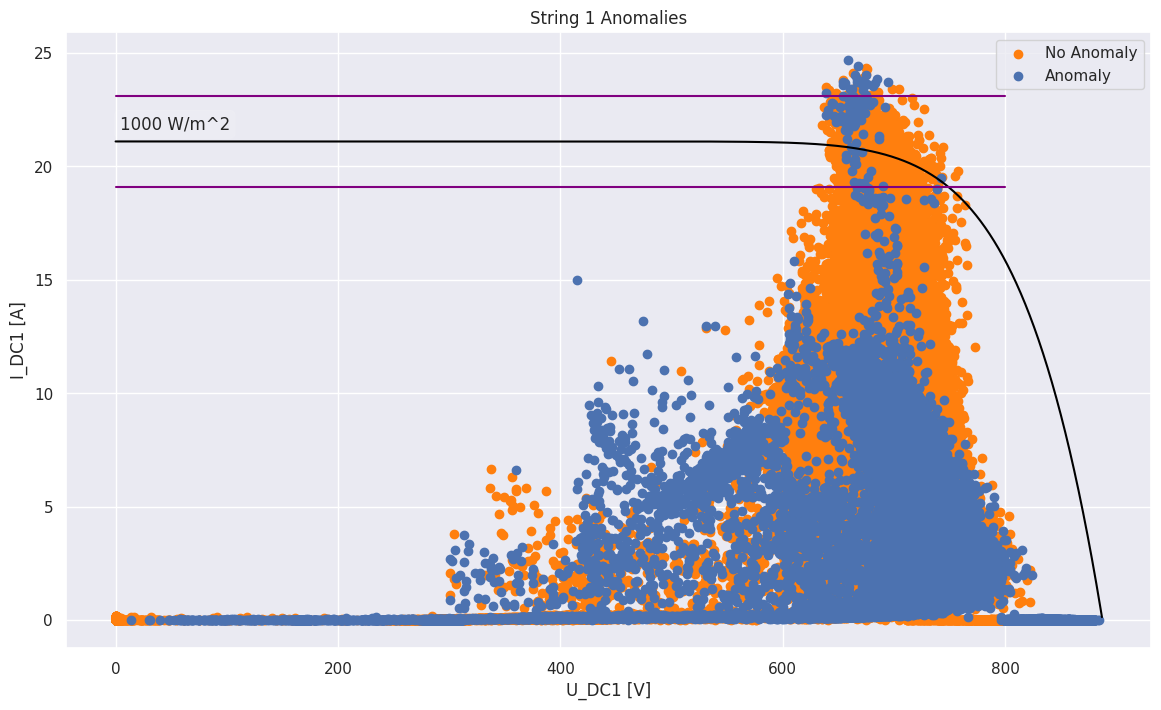

In [125]:
plt.figure(figsize=(14, 8))
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.plot(x, y, 'r', color='black')
plt.scatter(no_anomaly_ae['U_DC1'], no_anomaly_ae['I_DC1'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC1'], anomaly_ae['I_DC1'], label='Anomaly',color='b')
plt.xlabel('U_DC1 [V]')
plt.ylabel('I_DC1 [A]')
plt.legend()
plt.title('String 1 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))

upper_limit_idc = 21.1 + 2
lower_limit_idc = 21.1 - 2

upper_idc_xaxis =  np.arange(0,900,100)
upper_idc_yaxis = upper_limit_idc*np.ones(upper_idc_xaxis.shape[0])

lower_idc_xaxis =  np.arange(0,900,100)
lower_idc_yaxis = lower_limit_idc*np.ones(lower_idc_xaxis.shape[0])


plt.plot(upper_idc_xaxis, upper_idc_yaxis, 'r', color='purple')
plt.plot(lower_idc_xaxis, lower_idc_yaxis, 'r', color='purple')

In [126]:
sc_fault1 = ae_df[(ae_df['Anomaly'] == 1) & (ae_df['I_DC1']>=lower_limit_idc) & (ae_df['I_DC1']<=upper_limit_idc)]

In [127]:
index_sc1 = sc_fault1.index

In [128]:
ae_df.loc[index_sc1,'Anomaly_String1'] = 'Short Circuit'

In [129]:
ae_df[ae_df['Anomaly_String1'] == 'Short Circuit']

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
31225,2020-03-12 11:50:00,668.394,670.888,22.396,11.454,1,No Fault,Short Circuit,No Fault,14969.352024,7684.351152
31226,2020-03-12 11:55:00,663.448,665.344,22.170,11.290,1,No Fault,Short Circuit,No Fault,14708.642160,7511.733760
31227,2020-03-12 12:00:00,669.984,670.500,22.034,11.436,1,No Fault,Short Circuit,No Fault,14762.427456,7667.838000
31228,2020-03-12 12:05:00,670.876,668.702,22.368,11.496,1,No Fault,Short Circuit,No Fault,15006.154368,7687.398192
31231,2020-03-12 12:20:00,680.974,676.548,22.844,11.810,1,No Fault,Short Circuit,No Fault,15556.170056,7990.031880
...,...,...,...,...,...,...,...,...,...,...,...
146695,2023-05-07 11:35:00,673.276,32.594,19.260,0.086,1,No Fault,Short Circuit,No Fault,12967.295760,2.803084
146696,2023-05-07 11:40:00,668.560,32.076,19.272,0.086,1,No Fault,Short Circuit,No Fault,12884.488320,2.758536
146697,2023-05-07 11:45:00,663.888,31.850,19.306,0.090,1,No Fault,Short Circuit,No Fault,12817.021728,2.866500
146698,2023-05-07 11:50:00,666.554,32.410,19.238,0.090,1,No Fault,Short Circuit,No Fault,12823.165852,2.916900


### CIRCUITO ABIERTO

Todas aquellas fallas cuya corriente sea igual a 0

<ipython-input-130-72acb651a447>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')
<ipython-input-130-72acb651a447>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(voltage_zeros, current, 'r', color='purple')


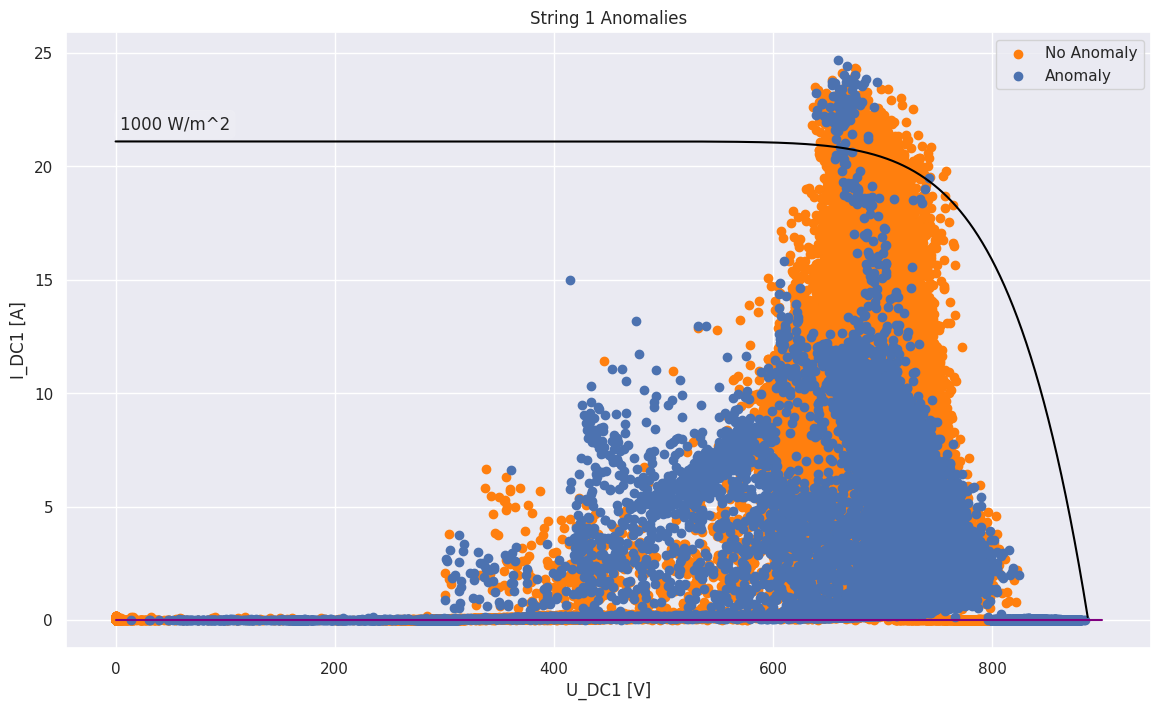

In [130]:
plt.figure(figsize=(14, 8))
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.plot(x, y, 'r', color='black')
plt.scatter(no_anomaly_ae['U_DC1'], no_anomaly_ae['I_DC1'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC1'], anomaly_ae['I_DC1'], label='Anomaly',color='b')
plt.xlabel('U_DC1 [V]')
plt.ylabel('I_DC1 [A]')
plt.legend()
plt.title('String 1 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))

current = np.zeros(10)
voltage_zeros = np.arange(0,1000,100)


plt.plot(voltage_zeros, current, 'r', color='purple')

In [131]:
oc_fault1 = ae_df[(ae_df['Anomaly'] == 1) & (ae_df['I_DC1']==0)]

In [132]:
oc_fault1.shape

(166, 11)

In [133]:
index_oc1 = oc_fault1.index

In [134]:
ae_df.loc[index_oc1,'Anomaly_String1'] = 'Open Circuit'

In [135]:
ae_df[(ae_df['Anomaly_String1'] == 'Open Circuit')]

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
5940,2019-09-14 15:30:00,833.476,835.932,0.0,0.06,1,No Fault,Open Circuit,No Fault,0.0,50.15592
5957,2019-09-14 16:55:00,824.730,826.150,0.0,0.06,1,No Fault,Open Circuit,No Fault,0.0,49.56900
5958,2019-09-14 17:00:00,822.650,824.114,0.0,0.06,1,No Fault,Open Circuit,No Fault,0.0,49.44684
5959,2019-09-14 17:05:00,819.342,819.976,0.0,0.06,1,No Fault,Open Circuit,No Fault,0.0,49.19856
15137,2019-11-18 06:35:00,843.602,849.354,0.0,0.05,1,No Fault,Open Circuit,No Fault,0.0,42.46770
...,...,...,...,...,...,...,...,...,...,...,...
101246,2021-07-23 16:25:00,837.212,837.172,0.0,0.04,1,No Fault,Open Circuit,No Fault,0.0,33.48688
101247,2021-07-23 16:30:00,822.262,822.214,0.0,0.04,1,No Fault,Open Circuit,No Fault,0.0,32.88856
101257,2021-07-23 17:20:00,803.504,803.420,0.0,0.04,1,No Fault,Open Circuit,No Fault,0.0,32.13680
101258,2021-07-23 17:25:00,798.938,798.866,0.0,0.04,1,No Fault,Open Circuit,No Fault,0.0,31.95464


### FALLA NO IDENTIFICADA

<ipython-input-136-554f1195f0cf>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')
<ipython-input-136-554f1195f0cf>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(upper_idc_xaxis, upper_idc_yaxis, 'r', color='purple')


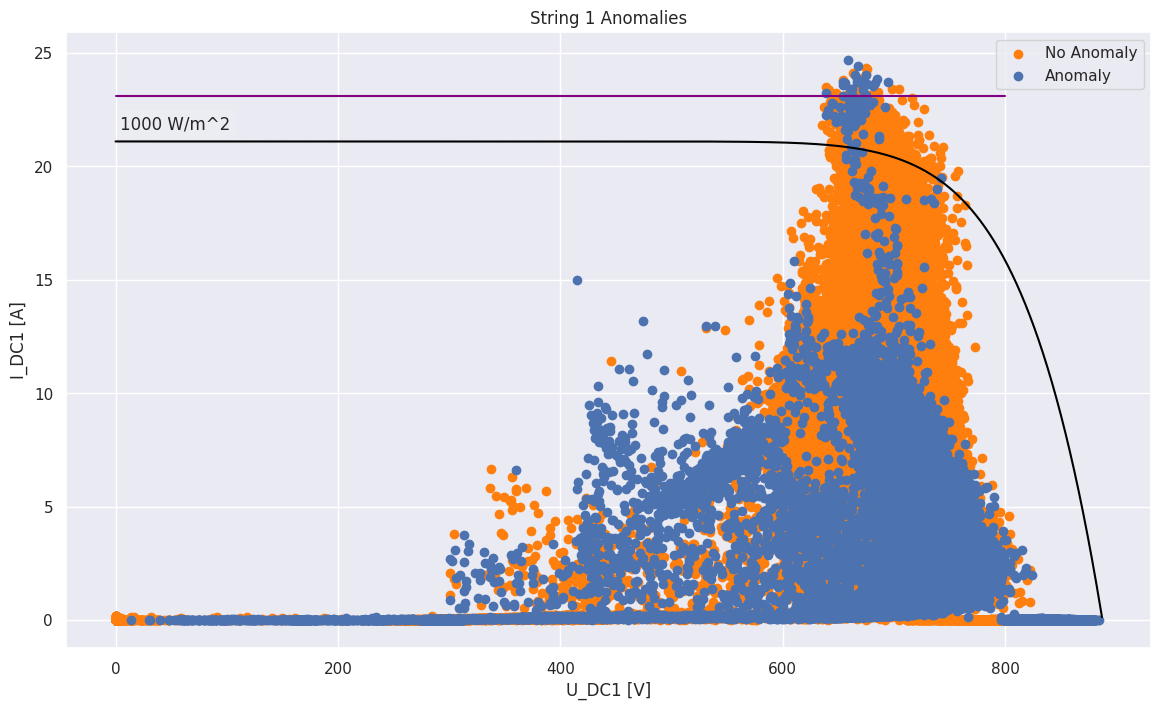

In [136]:
plt.figure(figsize=(14, 8))
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.plot(x, y, 'r', color='black')
plt.scatter(no_anomaly_ae['U_DC1'], no_anomaly_ae['I_DC1'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC1'], anomaly_ae['I_DC1'], label='Anomaly',color='b')
plt.xlabel('U_DC1 [V]')
plt.ylabel('I_DC1 [A]')
plt.legend()
plt.title('String 1 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))

upper_limit_idc = 21.1 + 2
lower_limit_idc = 21.1 - 2

upper_idc_xaxis =  np.arange(0,900,100)
upper_idc_yaxis = upper_limit_idc*np.ones(upper_idc_xaxis.shape[0])

lower_idc_xaxis =  np.arange(0,900,100)
lower_idc_yaxis = lower_limit_idc*np.ones(lower_idc_xaxis.shape[0])


plt.plot(upper_idc_xaxis, upper_idc_yaxis, 'r', color='purple')

In [137]:
unknown_1 = ae_df[(ae_df['Anomaly'] == 1) & (ae_df['I_DC1']>=upper_limit_idc)]

In [138]:
index_u1 = unknown_1.index

In [139]:
ae_df.loc[index_u1,'Anomaly_String1'] = 'Unknown'

In [140]:
ae_df[(ae_df['Anomaly_String1'] == 'Unknown')]

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
31224,2020-03-12 11:45:00,672.192,673.992,23.362,11.904,1,No Fault,Unknown,No Fault,15703.749504,8023.200768
31232,2020-03-12 12:25:00,674.644,673.786,23.128,11.954,1,No Fault,Unknown,No Fault,15603.166432,8054.437844
31233,2020-03-12 12:30:00,675.312,675.534,23.622,12.214,1,No Fault,Unknown,No Fault,15952.220064,8250.972276
31234,2020-03-12 12:35:00,671.600,673.854,23.620,12.254,1,No Fault,Unknown,No Fault,15863.192000,8257.406916
31238,2020-03-12 12:55:00,694.484,665.170,23.722,12.828,1,No Fault,Unknown,No Fault,16474.549448,8532.800760
34135,2020-04-02 10:40:00,662.528,651.838,23.392,11.942,1,No Fault,Unknown,No Fault,15497.854976,7784.249396
34140,2020-04-02 11:05:00,654.022,641.762,23.590,12.230,1,No Fault,Unknown,No Fault,15428.378980,7848.749260
34141,2020-04-02 11:10:00,667.402,641.216,24.432,13.054,1,No Fault,Unknown,No Fault,16305.965664,8370.433664
34293,2020-04-03 12:05:00,660.126,654.810,23.420,12.100,1,No Fault,Unknown,No Fault,15460.150920,7923.201000
37268,2020-04-24 12:20:00,683.116,677.840,23.686,12.056,1,No Fault,Unknown,No Fault,16180.285576,8172.039040


## STRING 2

<ipython-input-141-9d82fd2a20c6>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')


Text(0.1, 0.85, '1000 W/m^2')

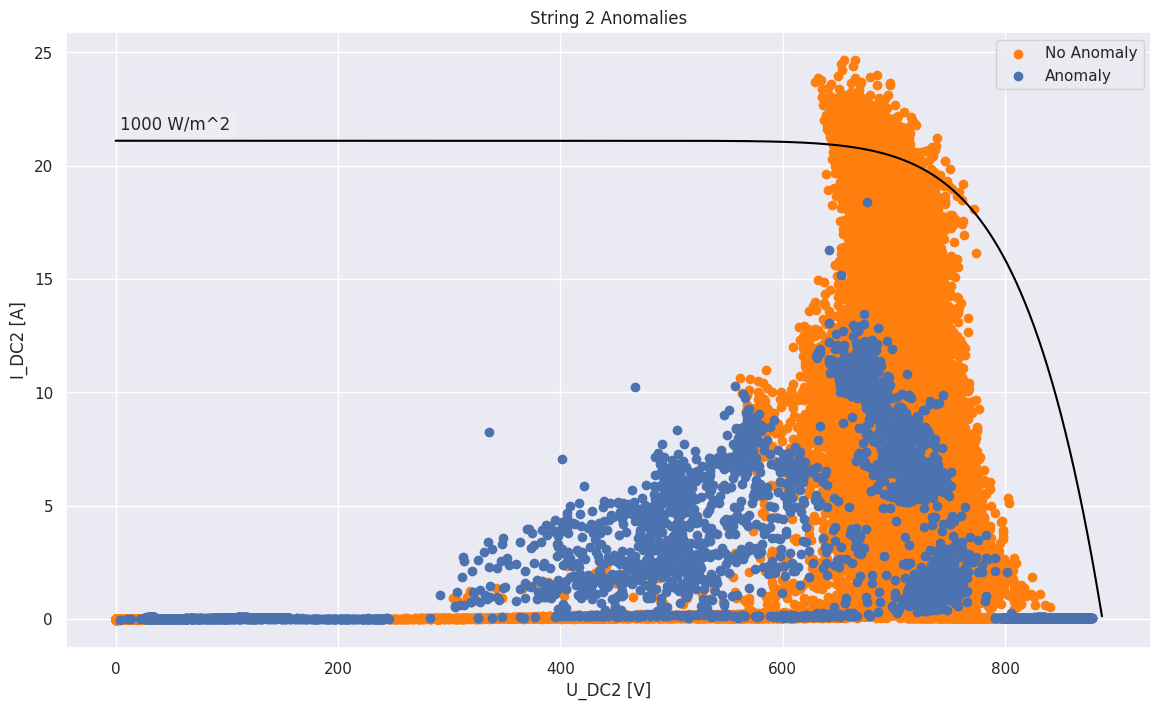

In [141]:
plt.figure(figsize=(14, 8))
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.plot(x, y, 'r', color='black')
plt.scatter(no_anomaly_ae['U_DC2'], no_anomaly_ae['I_DC2'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC2'], anomaly_ae['I_DC2'], label='Anomaly',color='b')
plt.xlabel('U_DC2 [V]')
plt.ylabel('I_DC2 [A]')
plt.legend()
plt.title('String 2 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))

In [142]:
ae_df['P_DC2'].mean()

2091.0071947071306

In [143]:
ae_df[(ae_df['P_DC2'] >= 2000) & (ae_df['P_DC2'] <= 2100) & (ae_df['I_DC2'] >= 4.5)]

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
5661,2019-09-12 16:00:00,725.734,454.512,5.222,4.508,1,No Fault,No Fault,No Fault,3789.782948,2048.940096
21607,2020-01-02 16:55:00,731.206,408.542,3.580,4.972,1,No Fault,Shading,No Fault,2617.717480,2031.270824
22445,2020-01-08 16:50:00,474.460,445.506,3.944,4.574,1,No Fault,Shading,No Fault,1871.270240,2037.744444
25625,2020-01-31 17:05:00,711.352,428.612,3.298,4.764,1,No Fault,Shading,No Fault,2346.038896,2041.907568


In [144]:
2091.0071947071306 - 2048.940096

42.067098707130754

In [145]:
2091.0071947071306 - 2121.659808

-30.65261329286932

In [146]:
ae_df[(ae_df['P_DC2'] >= 2100) & (ae_df['P_DC2'] <= 2150) & (ae_df['I_DC2'] >= 4.5)]

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
17098,2019-12-01 16:30:00,707.556,453.718,2.912,4.722,1,No Fault,Shading,No Fault,2060.403072,2142.456396
21606,2020-01-02 16:50:00,692.314,416.782,3.946,5.140,1,No Fault,Shading,No Fault,2731.871044,2142.259480
22723,2020-01-10 16:50:00,690.474,454.018,2.960,4.676,1,No Fault,Shading,No Fault,2043.803040,2122.988168
27276,2020-02-12 17:00:00,700.986,458.044,2.692,4.632,1,No Fault,Shading,No Fault,1887.054312,2121.659808


In [147]:
ae_df['I_DC2'].mean()

2.9501705940238563

In [148]:
ae_df['U_DC2'].mean()

554.7488825117355

### SOMBREO

<ipython-input-149-8c04cf0a9f06>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')
<ipython-input-149-8c04cf0a9f06>:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x_mean_power1_yaxis, y_mean_power1_yaxis, 'r', color='purple')
<ipython-input-149-8c04cf0a9f06>:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x_mean_power1_xaxis, y_mean_power1_xaxis, 'r', color='purple')
<ipython-input-149-8c04cf0a9f06>:37: UserWarning: color i

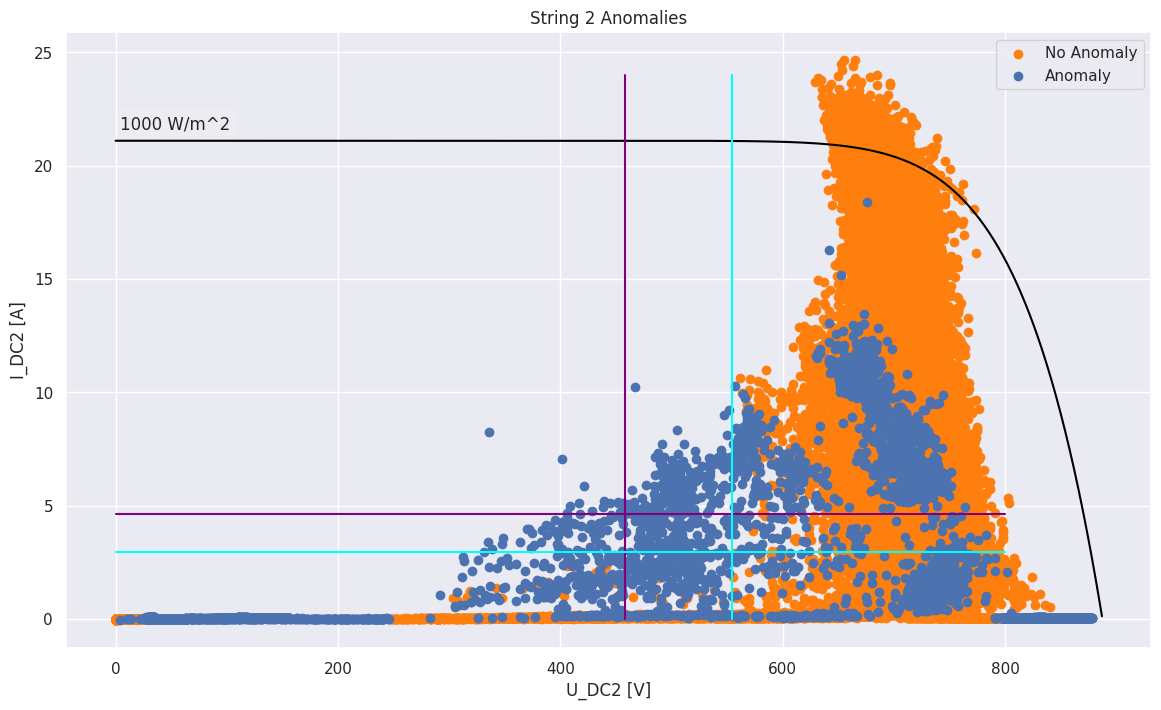

In [149]:
plt.figure(figsize=(14, 8))
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.plot(x, y, 'r', color='black')
plt.scatter(no_anomaly_ae['U_DC2'], no_anomaly_ae['I_DC2'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC2'], anomaly_ae['I_DC2'], label='Anomaly',color='b')
plt.xlabel('U_DC2 [V]')
plt.ylabel('I_DC2 [A]')
plt.legend()
plt.title('String 2 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))

x_mean_power1 = 458.044
y_mean_power1 = 4.632

y_mean_power1_yaxis = np.arange(0,25,1)
x_mean_power1_yaxis = x_mean_power1*np.ones(y_mean_power1_yaxis.shape[0])

x_mean_power1_xaxis = np.arange(0,900,100)
y_mean_power1_xaxis = y_mean_power1*np.ones(x_mean_power1_xaxis.shape[0])

x_mean_voltage1 = 554.7488825117355
y_mean_current1 = 2.9501705940238563

y_mean_voltage1_axis = np.arange(0,25,1)
x_mean_voltage1_axis = x_mean_voltage1*np.ones(y_mean_voltage1_axis.shape[0])

x_mean_current1_axis = np.arange(0,900,100)
y_mean_current1_axis = y_mean_current1*np.ones(x_mean_current1_axis.shape[0])

plt.plot(x_mean_power1_yaxis, y_mean_power1_yaxis, 'r', color='purple')
plt.plot(x_mean_power1_xaxis, y_mean_power1_xaxis, 'r', color='purple')
plt.plot(x_mean_voltage1_axis, y_mean_voltage1_axis, 'r', color='cyan')
plt.plot(x_mean_current1_axis, y_mean_current1_axis, 'r', color='cyan')

In [150]:
shading_power2 = ae_df[(ae_df['Anomaly'] == 1) & (ae_df['I_DC2']> 0) & (ae_df['U_DC2']> 0) & (ae_df['U_DC2']< x_mean_power1) & (ae_df['I_DC2']< y_mean_power1)]
shading_voltage2 = ae_df[(ae_df['Anomaly'] == 1) & (ae_df['I_DC2']>0) & (ae_df['U_DC1']>0) & (ae_df['U_DC2']< x_mean_voltage1) & (ae_df['I_DC2']< 19.1)]
shading_current2 = ae_df[(ae_df['Anomaly'] == 1) &(ae_df['I_DC2']>0) & (ae_df['U_DC2']>0) & (ae_df['I_DC2']< y_mean_current1) ]

In [151]:
shading_union = shading_power2.index.union(shading_voltage2.index).union(shading_current2.index)

In [152]:
ae_df.loc[shading_union,'Anomaly_String2'] = 'Shading'

In [153]:
ae_df[ae_df['Anomaly_String2'] == 'Shading']

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
364,2019-08-05 12:00:00,819.310,818.010,0.010,0.030,1,No Fault,Shading,Shading,8.193100,24.540300
431,2019-08-06 05:45:00,196.260,196.073,0.010,0.017,1,No Fault,Shading,Shading,1.962600,3.333241
576,2019-08-07 06:00:00,551.308,635.440,0.148,0.172,1,No Fault,Shading,Shading,81.593584,109.295680
718,2019-08-08 06:05:00,235.070,236.358,0.010,0.020,1,No Fault,Shading,Shading,2.350700,4.727160
974,2019-08-09 15:35:00,634.014,726.542,10.906,1.568,1,No Fault,Shading,Shading,6914.556684,1139.217856
...,...,...,...,...,...,...,...,...,...,...,...
150179,2023-05-31 16:05:00,556.382,680.244,4.686,1.954,1,No Fault,Shading,Shading,2607.206052,1329.196776
150196,2023-05-31 17:30:00,593.362,610.896,0.122,0.154,1,No Fault,Shading,Shading,72.390164,94.077984
150339,2023-06-02 05:40:00,94.104,94.308,0.004,0.010,1,No Fault,Shading,Shading,0.376416,0.943080
150395,2023-06-02 10:20:00,702.586,466.782,16.520,10.250,1,No Fault,No Fault,Shading,11606.720720,4784.515500


### CORTO CIRCUITO

<ipython-input-154-ec95234037ba>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')
<ipython-input-154-ec95234037ba>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(upper_idc_xaxis, upper_idc_yaxis, 'r', color='purple')
<ipython-input-154-ec95234037ba>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(lower_idc_xaxis, lower_idc_yaxis, 'r', color='purple')


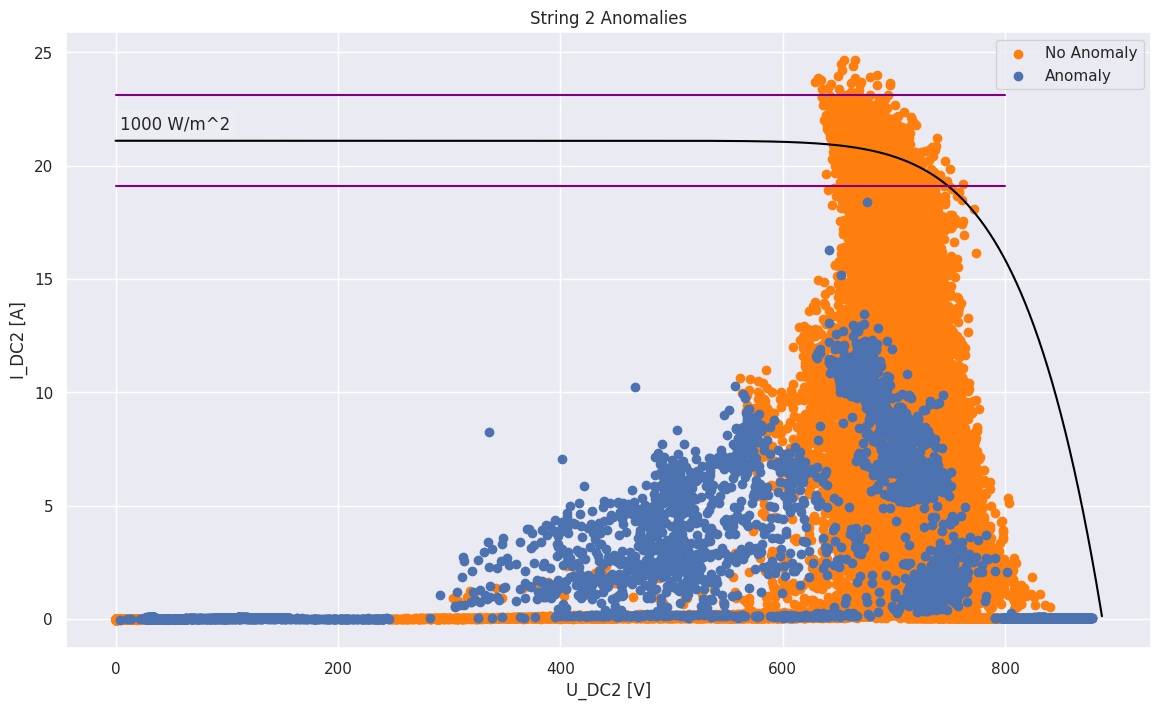

In [154]:
plt.figure(figsize=(14, 8))
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.plot(x, y, 'r', color='black')
plt.scatter(no_anomaly_ae['U_DC2'], no_anomaly_ae['I_DC2'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC2'], anomaly_ae['I_DC2'], label='Anomaly',color='b')
plt.xlabel('U_DC2 [V]')
plt.ylabel('I_DC2 [A]')
plt.legend()
plt.title('String 2 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))

upper_limit_idc = 21.1 + 2
lower_limit_idc = 21.1 - 2

upper_idc_xaxis =  np.arange(0,900,100)
upper_idc_yaxis = upper_limit_idc*np.ones(upper_idc_xaxis.shape[0])

lower_idc_xaxis =  np.arange(0,900,100)
lower_idc_yaxis = lower_limit_idc*np.ones(lower_idc_xaxis.shape[0])


plt.plot(upper_idc_xaxis, upper_idc_yaxis, 'r', color='purple')
plt.plot(lower_idc_xaxis, lower_idc_yaxis, 'r', color='purple')

In [155]:
sc_fault2 = ae_df[(ae_df['Anomaly'] == 1) & (ae_df['I_DC2']>=lower_limit_idc) & (ae_df['I_DC2']<=upper_limit_idc)]

In [156]:
sc_fault2.shape

(0, 11)

In [157]:
index_sc2 = sc_fault2.index

In [158]:
ae_df.loc[index_sc2,'Anomaly_String2'] = 'Short Circuit'

In [159]:
ae_df[ae_df['Anomaly_String2'] == 'Short Circuit']

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2


No hay fallas de corto circuito

### CIRCUITO ABIERTO

Todas aquellas fallas cuya corriente sea igual a 0

<ipython-input-160-70a85ca723a0>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')
<ipython-input-160-70a85ca723a0>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(voltage_zeros, current, 'r', color='purple')


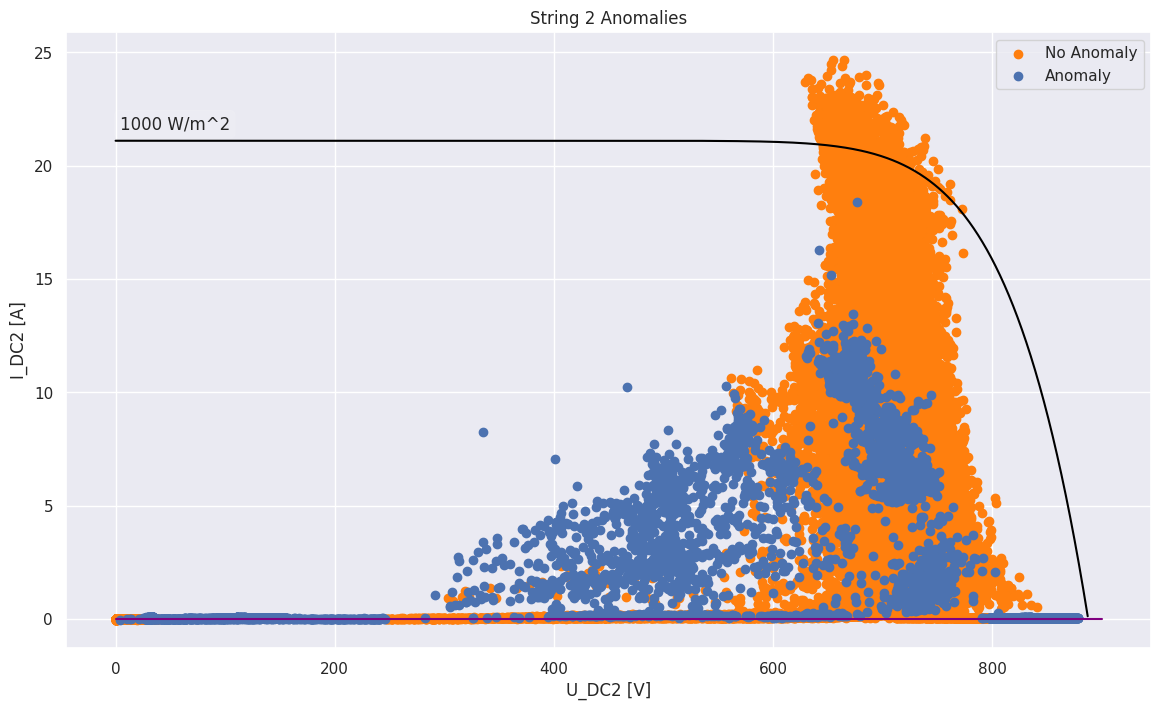

In [160]:
plt.figure(figsize=(14, 8))
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.plot(x, y, 'r', color='black')
plt.scatter(no_anomaly_ae['U_DC2'], no_anomaly_ae['I_DC2'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC2'], anomaly_ae['I_DC2'], label='Anomaly',color='b')
plt.xlabel('U_DC2 [V]')
plt.ylabel('I_DC2 [A]')
plt.legend()
plt.title('String 2 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))

current = np.zeros(10)
voltage_zeros = np.arange(0,1000,100)


plt.plot(voltage_zeros, current, 'r', color='purple')

In [161]:
oc_fault2 = ae_df[(ae_df['Anomaly'] == 1) & (ae_df['I_DC2']==0)]

In [162]:
oc_fault2.shape

(1, 11)

In [163]:
index_oc2 = oc_fault2.index

In [164]:
ae_df.loc[index_oc2,'Anomaly_String2'] = 'Open Circuit'

In [165]:
ae_df[(ae_df['Anomaly_String2'] == 'Open Circuit')]

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
91943,2021-05-19 05:45:00,128.377,128.56,0.058,0.0,1,No Fault,Shading,Open Circuit,7.445866,0.0


In [166]:
ae_df

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2
0,2019-08-02 16:25:00,777.010,768.710,2.700,2.607,0,No Fault,No Fault,No Fault,2097.927000,2004.026970
1,2019-08-02 16:30:00,761.130,745.964,3.862,3.748,0,No Fault,No Fault,No Fault,2939.484060,2795.873072
2,2019-08-02 16:35:00,736.754,742.908,3.228,3.192,0,No Fault,No Fault,No Fault,2378.241912,2371.362336
3,2019-08-02 16:40:00,731.928,732.224,2.568,2.484,0,No Fault,No Fault,No Fault,1879.591104,1818.844416
4,2019-08-02 16:45:00,723.546,720.698,1.654,1.640,0,No Fault,No Fault,No Fault,1196.745084,1181.944720
...,...,...,...,...,...,...,...,...,...,...,...
150393,2023-06-02 10:10:00,712.860,698.410,15.514,15.758,0,No Fault,No Fault,No Fault,11059.310040,11005.544780
150394,2023-06-02 10:15:00,703.810,696.148,16.136,16.278,0,No Fault,No Fault,No Fault,11356.678160,11331.897144
150395,2023-06-02 10:20:00,702.586,466.782,16.520,10.250,1,No Fault,No Fault,Shading,11606.720720,4784.515500
150396,2023-06-02 10:25:00,703.080,32.316,15.754,0.080,1,No Fault,No Fault,Shading,11076.322320,2.585280


### FALLA NO IDENTIFICADA

<ipython-input-167-74750d259939>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')
<ipython-input-167-74750d259939>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(upper_idc_xaxis, upper_idc_yaxis, 'r', color='purple')


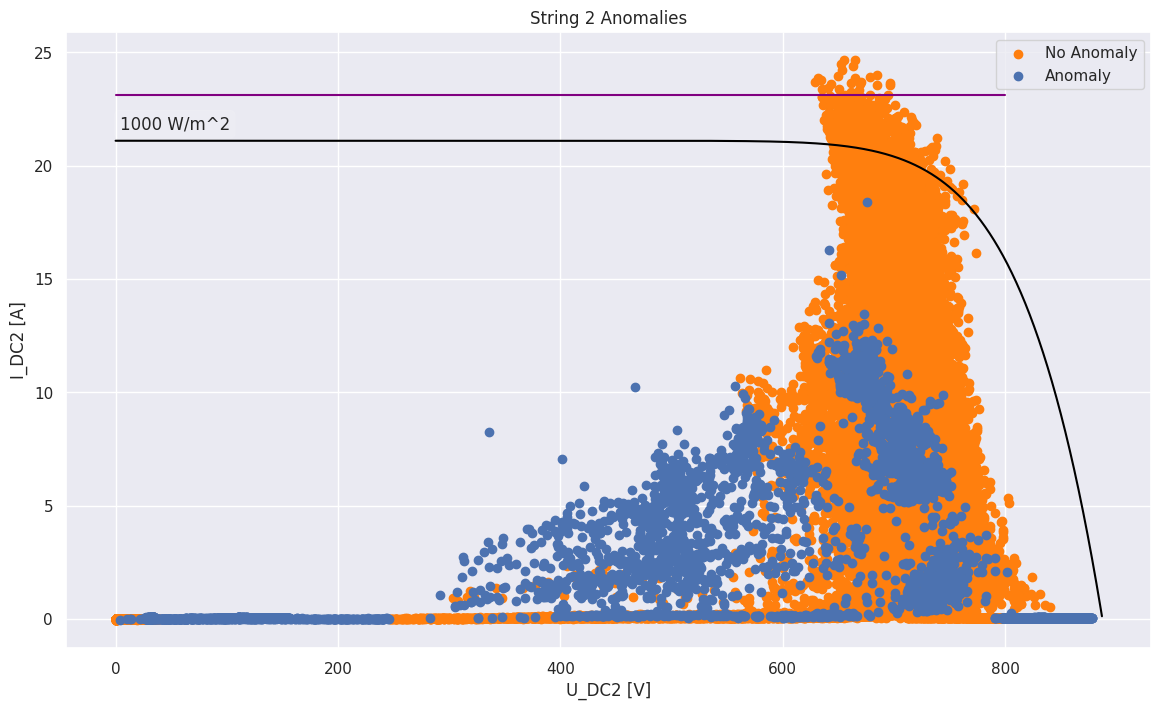

In [167]:
plt.figure(figsize=(14, 8))
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.plot(x, y, 'r', color='black')
plt.scatter(no_anomaly_ae['U_DC2'], no_anomaly_ae['I_DC2'], label='No Anomaly',color='#ff7f0e')
plt.scatter(anomaly_ae['U_DC2'], anomaly_ae['I_DC2'], label='Anomaly',color='b')
plt.xlabel('U_DC2 [V]')
plt.ylabel('I_DC2 [A]')
plt.legend()
plt.title('String 2 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))

upper_limit_idc = 21.1 + 2
lower_limit_idc = 21.1 - 2

upper_idc_xaxis =  np.arange(0,900,100)
upper_idc_yaxis = upper_limit_idc*np.ones(upper_idc_xaxis.shape[0])

lower_idc_xaxis =  np.arange(0,900,100)
lower_idc_yaxis = lower_limit_idc*np.ones(lower_idc_xaxis.shape[0])


plt.plot(upper_idc_xaxis, upper_idc_yaxis, 'r', color='purple')

In [168]:
unknown_2 = ae_df[(ae_df['Anomaly'] == 1) & (ae_df['I_DC2']>=upper_limit_idc)]

In [169]:
index_u2 = unknown_2.index

In [170]:
ae_df.loc[index_u2,'Anomaly_String2'] = 'Unknown'

In [171]:
ae_df[(ae_df['Anomaly_String2'] == 'Unknown')]

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly,Label,Anomaly_String1,Anomaly_String2,P_DC1,P_DC2


## ETIQUETADO GENERAL

In [172]:
conditions = [
    ((ae_df['Anomaly_String1'] == 'Unknown') | (ae_df['Anomaly_String2'] == 'Unknown')),
    ((ae_df['Anomaly_String1'] == 'Open Circuit') | (ae_df['Anomaly_String2'] == 'Open Circuit')),
    ((ae_df['Anomaly_String1'] == 'Short Circuit') | (ae_df['Anomaly_String2'] == 'Short Circuit')),
    ((ae_df['Anomaly_String1'] == 'Shading') | (ae_df['Anomaly_String2'] == 'Shading'))
]

choices = ['Unknown', 'Open Circuit', 'Short Circuit', 'Shading']

ae_df['Label'] = np.select(conditions, choices, default='No Fault')

In [173]:
no_fault = ae_df[ae_df['Label']=='No Fault']
shading = ae_df[ae_df['Label']=='Shading']
short_circuit = ae_df[ae_df['Label']=='Short Circuit']
open_circuit = ae_df[ae_df['Label']=='Open Circuit']
unknown = ae_df[ae_df['Label']=='Unknown']

<ipython-input-196-303078d2ced2>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')


Text(0.1, 0.85, '1000 W/m^2')

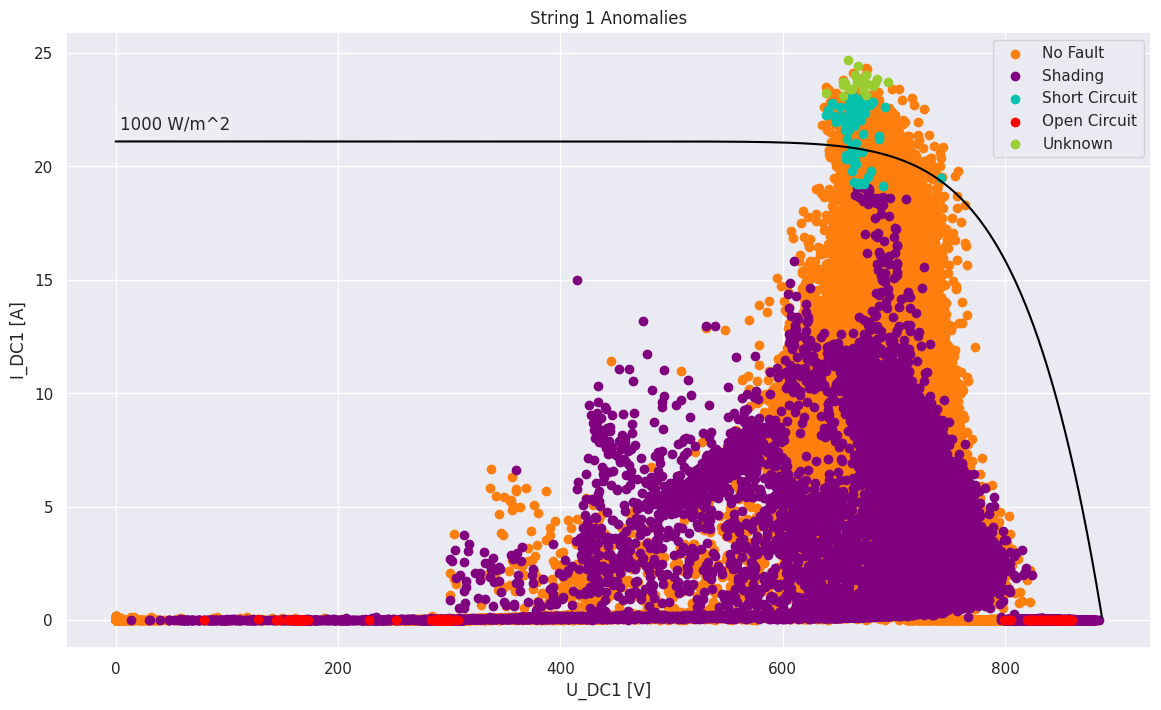

In [196]:
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.figure(figsize=(14, 8))
plt.plot(x, y, 'r', color='black')
plt.scatter(no_fault['U_DC1'], no_fault['I_DC1'], label='No Fault',color='#ff7f0e')
plt.scatter(shading['U_DC1'], shading['I_DC1'], label='Shading',color='purple')
plt.scatter(short_circuit['U_DC1'], short_circuit['I_DC1'], label='Short Circuit',color= '#06c2ac')
plt.scatter(open_circuit['U_DC1'], open_circuit['I_DC1'], label='Open Circuit',color='red')
plt.scatter(unknown['U_DC1'], unknown['I_DC1'], label='Unknown',color='yellowgreen')
plt.xlabel('U_DC1 [V]')
plt.ylabel('I_DC1 [A]')
plt.legend()
plt.title('String 1 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))


<ipython-input-197-83e8e99d2175>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(x, y, 'r', color='black')


Text(0.1, 0.85, '1000 W/m^2')

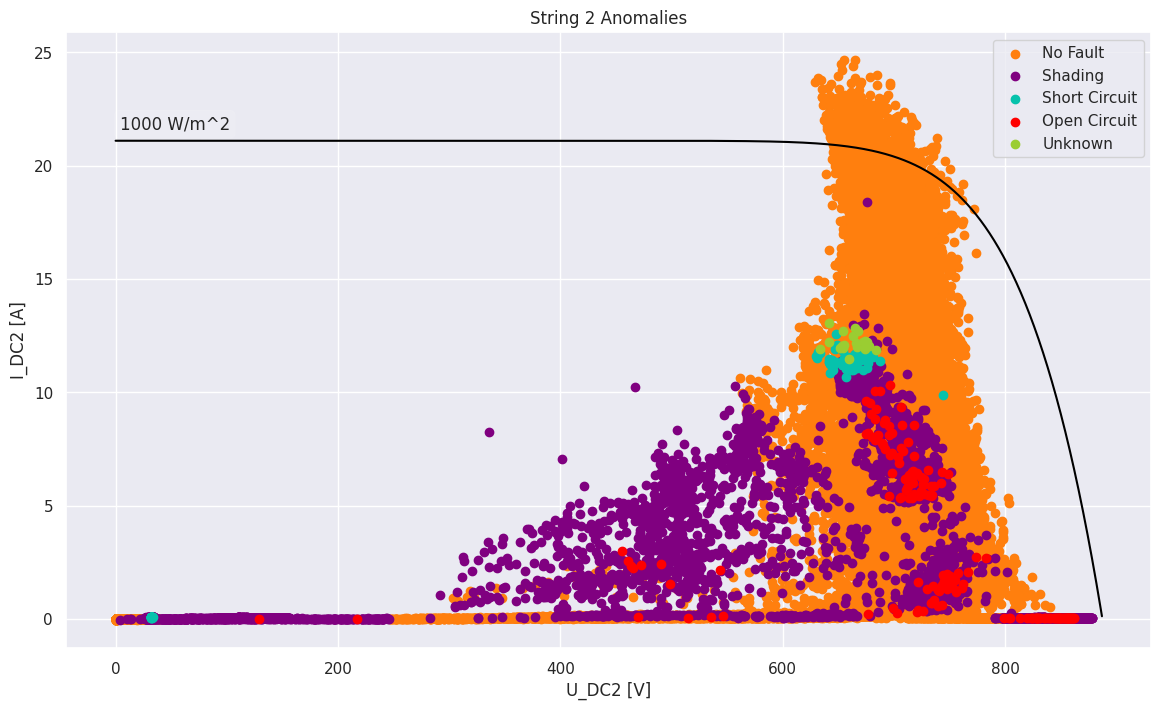

In [197]:
x = np.arange(0.01,887.4,1)
y = -7084864.500*np.exp(-11291.87/x)+21.10

plt.figure(figsize=(14, 8))
plt.plot(x, y, 'r', color='black')
plt.scatter(no_fault['U_DC2'], no_fault['I_DC2'], label='No Fault',color='#ff7f0e')
plt.scatter(shading['U_DC2'], shading['I_DC2'], label='Shading',color='purple')
plt.scatter(short_circuit['U_DC2'], short_circuit['I_DC2'], label='Short Circuit',color= '#06c2ac')
plt.scatter(open_circuit['U_DC2'], open_circuit['I_DC2'], label='Open Circuit',color='red')
plt.scatter(unknown['U_DC2'], unknown['I_DC2'], label='Unknown',color='yellowgreen')
plt.xlabel('U_DC2 [V]')
plt.ylabel('I_DC2 [A]')
plt.legend()
plt.title('String 2 Anomalies')

plt.annotate('1000 W/m^2', xy=(0.1, 0.85), xycoords='axes fraction',
             fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', alpha=0.1, facecolor='white'))


## ANÁLISIS DE ETIQUETADO

In [198]:
labeled_df = ae_df[['Timestamp','U_DC1','U_DC2','I_DC1','I_DC2','Label']]

<ipython-input-199-772ecc8ae998>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()/1000)


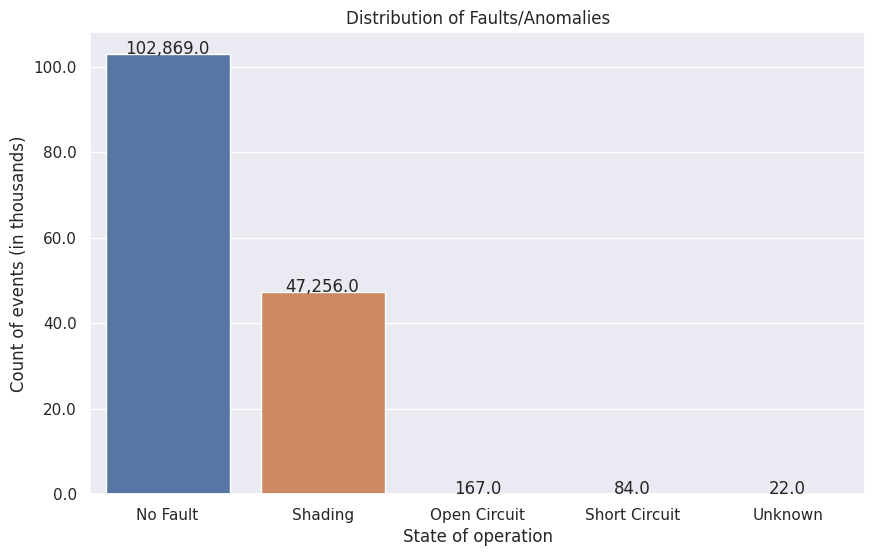

In [199]:
plt.figure(figsize=(10, 6))

# Calculate counts and sort in descending order
order =labeled_df['Label'].value_counts().index
ax = sns.countplot(x='Label',data=labeled_df,order=order)
plt.title('Distribution of Faults/Anomalies')
plt.xlabel('State of operation')
plt.ylabel('Count of events (in thousands)')

ax.set_yticklabels(ax.get_yticks()/1000)

for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = height+0.2,
            s = '{:,}'.format(height),  # Original value here
            ha = 'center')

plt.show()

In [200]:
order

Index(['No Fault', 'Shading', 'Open Circuit', 'Short Circuit', 'Unknown'], dtype='object')

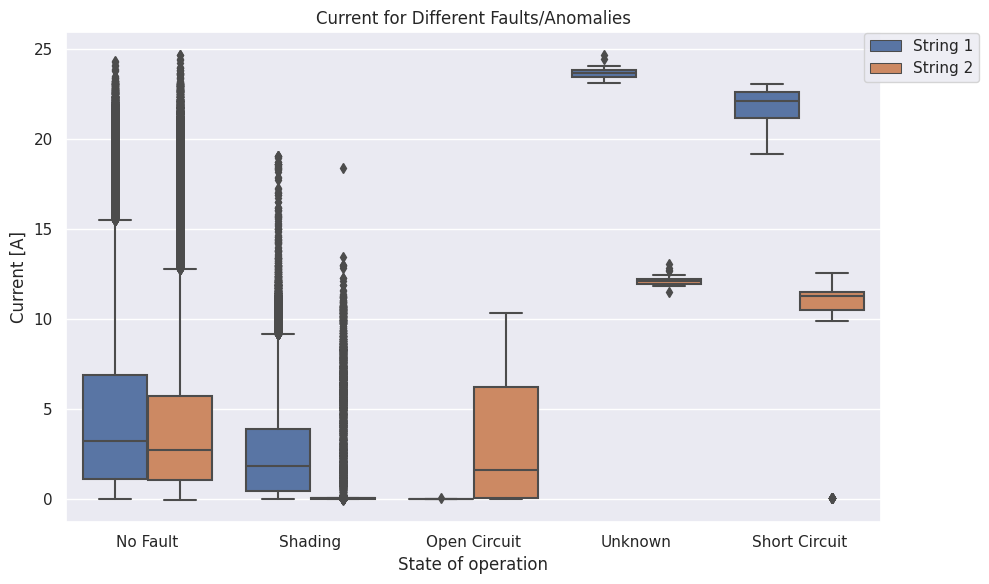

In [201]:
# Create a new dataframe
ae_df_new = pd.concat([
    ae_df[['Label', 'I_DC1']].rename(columns={'I_DC1': 'Current'}).assign(String='String 1'),
    ae_df[['Label', 'I_DC2']].rename(columns={'I_DC2': 'Current'}).assign(String='String 2')
])

plt.figure(figsize=(10, 6))
ax =sns.boxplot(x='Label', y='Current', hue='String', data=ae_df_new)
ax.legend(loc='upper right', bbox_to_anchor=(1.13,1.015))
plt.title('Current for Different Faults/Anomalies')
plt.xlabel('State of operation')
plt.ylabel('Current [A]')

plt.tight_layout()
plt.show()

In [202]:
ae_df_new[(ae_df_new['Label']=='Shading') & (ae_df_new['String']=='String 2')]

,Label,Current,String
364,Shading,0.030,String 2
431,Shading,0.017,String 2
576,Shading,0.172,String 2
718,Shading,0.020,String 2
973,Shading,3.244,String 2
...,...,...,...
150179,Shading,1.954,String 2
150196,Shading,0.154,String 2
150339,Shading,0.010,String 2
150395,Shading,10.250,String 2


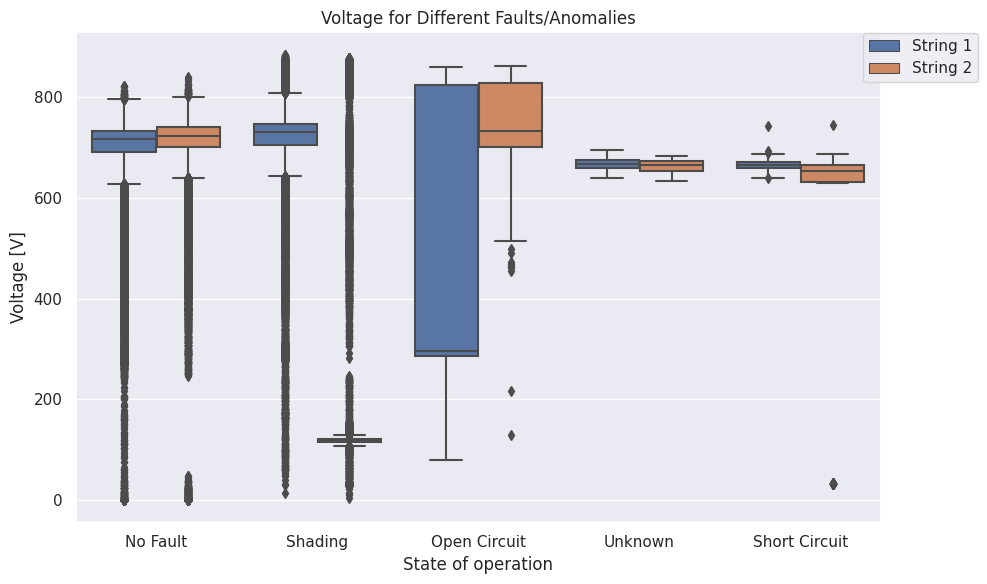

In [203]:
# Create a new dataframe
ae_df_new = pd.concat([
    ae_df[['Label', 'U_DC1']].rename(columns={'U_DC1': 'Voltage'}).assign(String='String 1'),
    ae_df[['Label', 'U_DC2']].rename(columns={'U_DC2': 'Voltage'}).assign(String='String 2')
])

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Label', y='Voltage', hue='String', data=ae_df_new)
ax.legend(loc='upper right', bbox_to_anchor=(1.13,1.015))
plt.title('Voltage for Different Faults/Anomalies')
plt.xlabel('State of operation')
plt.ylabel('Voltage [V]')

plt.tight_layout()
plt.show()

In [204]:
#labeled_df.to_csv('df_with_labels.csv', sep=';', index=False, encoding='utf-8')